In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.stats import entropy

In [3]:
from temp_scaling import optimal_temp_scale, rescale_temp


In [4]:
def plot_entropy(myax, inclass, outclass, label, bins = np.logspace(-8, 0.5, num=30), show_legend = False, show_xlabel=False, show_ylabel=False):
    myax.set_title(str(label), fontsize=12)
    myax.set_xscale('log')
    #bins = 10 ** np.linspace(-8, 0.5, 30)
    myax.hist(inclass, bins=bins, color='red', label='In Class')
    myax.hist(outclass, bins=bins, color='black', alpha=0.3, label = 'Out of Class')
    myax.set_ylim((0, 1000))
    if show_xlabel:
        myax.set_xlabel('Entropy')
    if show_ylabel:
        myax.set_ylabel('Count')
    if show_legend:
        myax.legend()

In [5]:
swag_inclass = np.load('CIFAR5/unc_1_swag.npz')
swag_outclass = np.load('CIFAR5/unc_0_swag.npz')

swagdiag_inclass = np.load('CIFAR5/unc_1_swagdiag.npz')
swagdiag_outclass = np.load('CIFAR5/unc_0_swagdiag.npz')

drop_inclass = np.load('CIFAR5/unc_1_drop.npz')
drop_outclass = np.load('CIFAR5/unc_0_drop.npz')

sgd_inclass = np.load('CIFAR5/unc_1_sgd.npz')
sgd_outclass = np.load('CIFAR5/unc_0_sgd.npz')

swa_inclass = np.load('CIFAR5/unc_1_swa.npz')
swa_outclass = np.load('CIFAR5/unc_0_swa.npz')

swagdrop_inclass = np.load('CIFAR5/unc_1_swagdrop.npz')
swagdrop_outclass = np.load('CIFAR5/unc_0_swagdrop.npz')

In [6]:
sgd_val = np.load('CIFAR5/unc_sgd_val.npz')
ts_inclass = np.load('CIFAR5/unc_sgd.npz')
ts_outclass = np.load('CIFAR5/unc_0_ts.npz')

In [7]:
T_sgd, rescaled_sgd = optimal_temp_scale(sgd_val["predictions"], sgd_val["targets"], max_iter=50, lr=1e-3)


Before temperature - NLL: 0.177
After temperature - NLL: 0.162 , Temperature: tensor([1.1490], requires_grad=True)


/home/wesley/Desktop/tesla/swa_uncertainties/experiments/uncertainty/temp_scaling.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return T.item(), F.softmax(logits / T).data.numpy()


In [8]:
ts_inclass_predictions = rescale_temp(ts_inclass['predictions'], T_sgd)
ts_outclass_predictions = rescale_temp(ts_outclass['predictions'], T_sgd)

In [9]:
eps = 1e-12
ts_inclass_entropies = -np.sum(np.log(ts_inclass_predictions + eps) * ts_inclass_predictions, axis=1)
ts_outclass_entropies = -np.sum(np.log(ts_outclass_predictions + eps) * ts_outclass_predictions, axis=1)

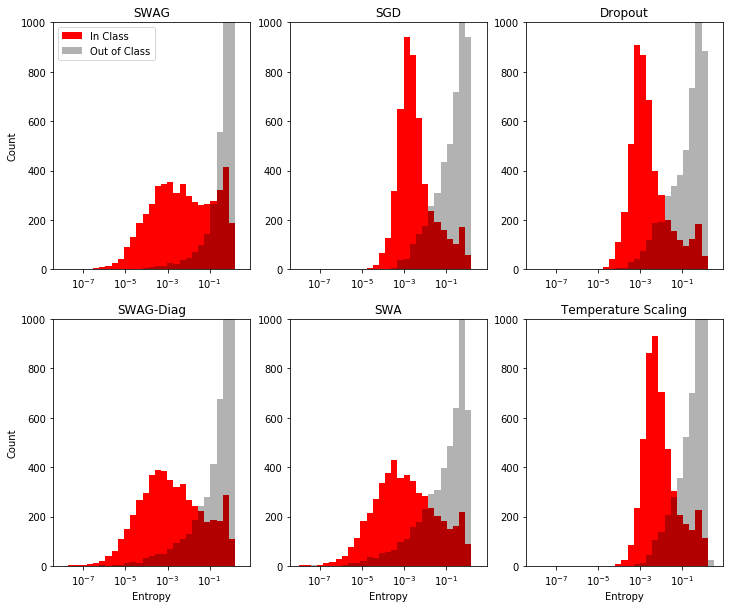

In [10]:
plt.rcParams["figure.figsize"] = (12,10)
f, axarr = plt.subplots(2,3)
plot_entropy(axarr[0,0], swag_inclass['entropies'], swag_outclass['entropies'], 'SWAG', show_legend=True, show_ylabel=True)
plot_entropy(axarr[0,1], sgd_inclass['entropies'], sgd_outclass['entropies'], 'SGD')
plot_entropy(axarr[0,2], drop_inclass['entropies'], drop_outclass['entropies'], 'Dropout')
plot_entropy(axarr[1,0], swagdiag_inclass['entropies'], swagdiag_outclass['entropies'], 'SWAG-Diag', show_ylabel=True, show_xlabel=True)
plot_entropy(axarr[1,1], swa_inclass['entropies'], swa_outclass['entropies'], 'SWA', show_xlabel=True)
plot_entropy(axarr[1,2], ts_inclass_entropies, ts_outclass_entropies, 'Temperature Scaling', show_xlabel=True)
plt.savefig('/home/wesley/Documents/Papers/udl_paper_source/icml/plots/pics/c55_entropy_hists.pdf')

In [11]:
np.savez('/home/wesley/Documents/Papers/udl_paper_source/icml/plots/data/c55_entropies.npz',
        swag={'in':swag_inclass['entropies'], 'out':swag_outclass['entropies']},
        swag_diag={'in':swagdiag_inclass['entropies'], 'out': swagdiag_outclass['entropies']},
         drop={'in':drop_inclass['entropies'], 'out': drop_outclass['entropies']},
         sgd={'in':sgd_inclass['entropies'], 'out':sgd_outclass['entropies']},
         swa={'in':swa_inclass['entropies'], 'out':swa_outclass['entropies']},
         ts={'in':ts_inclass_entropies, 'out':ts_outclass_entropies, 'temp':T_sgd}
        )

In [12]:
def binned_kl_distance(dist1, dist2, smooth=1e-7, bins = np.logspace(-8, 0.5, num=30)):
    dist1_pdf, _ = np.histogram(dist1, bins)
    dist2_pdf, _ = np.histogram(dist2, bins)
    
    dist1_pdf = dist1_pdf + smooth
    dist2_pdf = dist2_pdf + smooth
    
    dist1_pdf_normalized = dist1_pdf / dist1_pdf.sum()
    dist2_pdf_normalized = dist2_pdf / dist2_pdf.sum()
    
    kldist = entropy(dist1_pdf_normalized, dist2_pdf_normalized) + entropy(dist2_pdf_normalized, dist1_pdf_normalized)
    print(kldist)
    return kldist

In [13]:
binned_kl_distance(swag_inclass['entropies'], swag_outclass['entropies'])
binned_kl_distance(sgd_inclass['entropies'], sgd_outclass['entropies'])
binned_kl_distance(drop_inclass['entropies'], drop_outclass['entropies'])
binned_kl_distance( swagdiag_inclass['entropies'], swagdiag_outclass['entropies'])
binned_kl_distance(swa_inclass['entropies'], swa_outclass['entropies'])
binned_kl_distance(swagdrop_inclass['entropies'], swagdrop_outclass['entropies'])
binned_kl_distance(ts_inclass_entropies, ts_outclass_entropies)

3.3122097048920525
3.147469679750145
3.033979772295697
2.267619554875406
1.6859929584326525
2.2411515900226866
2.9845347377810465


2.9845347377810465

In [14]:
np.savez(file='entropy_results.npz',
       swag={'inclass': swag_inclass['entropies'], 'outclass': swag_outclass['entropies']},
       sgd={'inclass': sgd_inclass['entropies'], 'outclass': sgd_outclass['entropies']},
       drop={'inclass': drop_inclass['entropies'], 'outclass': drop_outclass['entropies']},
       swagdiag={'inclass': swagdiag_inclass['entropies'], 'outclass': swagdiag_outclass['entropies']},
       swa={'inclass': swa_inclass['entropies'], 'outclass': swa_outclass['entropies']},
       swagdrop={'inclass': swagdrop_inclass['entropies'], 'outclass': swagdrop_outclass['entropies']},
       )

In [15]:
smooth_range = np.logspace(start=-30, stop=-1,num=100)
smoothed_dists = np.zeros_like(smooth_range)
for i in range(100):
    smoothed_dists[i] = binned_kl_distance(swag_inclass['entropies'], swag_outclass['entropies'], smooth=smooth_range[i])

4.254888050531469
4.2428820462385035
4.230876041945539
4.218870037652574
4.206864033359609
4.194858029066644
4.18285202477368
4.170846020480714
4.1588400161877495
4.146834011894785
4.134828007601819
4.122822003308855
4.110815999015889
4.098809994722925
4.08680399042996
4.0747979861369945
4.06279198184403
4.050785977551065
4.038779973258101
4.026773968965135
4.014767964672171
4.002761960379205
3.9907559560862405
3.978749951793276
3.9667439475003103
3.9547379432073457
3.942731938914381
3.9307259346214156
3.918719930328451
3.9067139260354864
3.894707921742521
3.8827019174495563
3.8706959131565917
3.858689908863627
3.8466839045706616
3.834677900277697
3.8226718959847314
3.810665891691767
3.7986598873988022
3.7866538831058376
3.774647878812872
3.7626418745199075
3.750635870226943
3.7386298659339774
3.726623861641013
3.7146178573480473
3.7026118530550827
3.690605848762118
3.6785998444691526
3.666593840176188
3.654587835883223
3.642581831590258
3.6305758272972932
3.618569823004328
3.606563818

In [16]:
smooth_range

array([1.00000000e-30, 1.96304065e-30, 3.85352859e-30, 7.56463328e-30,
       1.48496826e-29, 2.91505306e-29, 5.72236766e-29, 1.12332403e-28,
       2.20513074e-28, 4.32876128e-28, 8.49753436e-28, 1.66810054e-27,
       3.27454916e-27, 6.42807312e-27, 1.26185688e-26, 2.47707636e-26,
       4.86260158e-26, 9.54548457e-26, 1.87381742e-25, 3.67837977e-25,
       7.22080902e-25, 1.41747416e-24, 2.78255940e-24, 5.46227722e-24,
       1.07226722e-23, 2.10490414e-23, 4.13201240e-23, 8.11130831e-23,
       1.59228279e-22, 3.12571585e-22, 6.13590727e-22, 1.20450354e-21,
       2.36448941e-21, 4.64158883e-21, 9.11162756e-21, 1.78864953e-20,
       3.51119173e-20, 6.89261210e-20, 1.35304777e-19, 2.65608778e-19,
       5.21400829e-19, 1.02353102e-18, 2.00923300e-18, 3.94420606e-18,
       7.74263683e-18, 1.51991108e-17, 2.98364724e-17, 5.85702082e-17,
       1.14975700e-16, 2.25701972e-16, 4.43062146e-16, 8.69749003e-16,
       1.70735265e-15, 3.35160265e-15, 6.57933225e-15, 1.29154967e-14,
      

Text(0,0.5,'JS Distance')

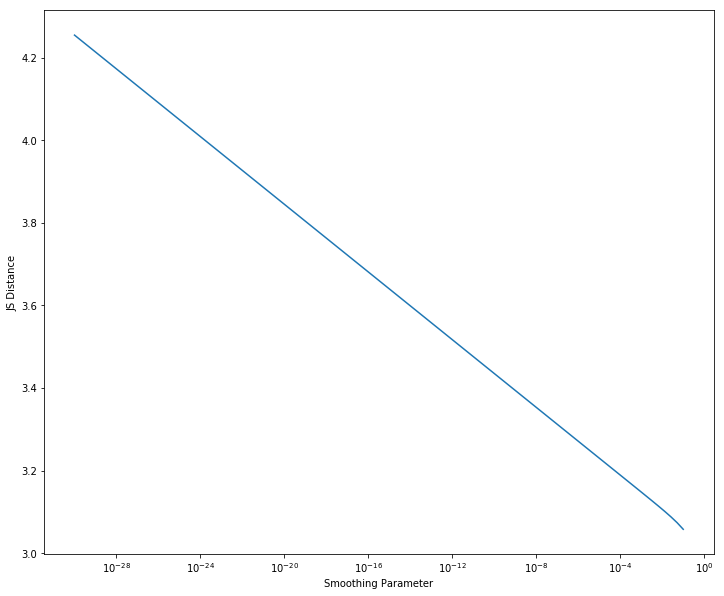

In [17]:
plt.semilogx(smooth_range, smoothed_dists)
plt.xlabel('Smoothing Parameter')
plt.ylabel('JS Distance')

In [18]:
np.log(np.log(5))

0.47588499532711054